In [1]:
# General Dependencies
import timeit, os
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate
import trefide.preprocess as preprocess

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose

# Plot & Video Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot, correlation_traces, snr_per_frame, nearest_frame_corr
from trefide.video import write_mpl, play_cv2

# Set Data Information
dataset = "Q-State Bio"
filename = os.path.join("..", "data", "prepared_sampleMovie.npy")

%load_ext autoreload
%autoreload 2

from trefide.decimation import downsample_image, downsample_signal, upsample_image, upsample_signal

In [2]:
# Load Data
stim = io.loadmat("../data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("../data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [3]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [4]:
signals = signals[:,:-1].copy() # make sure signals contiguous in memory
T = signals.shape[-1]

In [9]:
d1,d2 = 80,800
footprints = np.reshape(data['A'], (d1,d2,N), order='F')

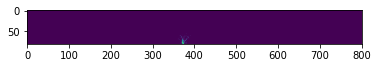

In [11]:
plt.imshow(footprints[:,:,0])
plt.show()

In [14]:
fp_ds = downsample_image(d1,d2,8,footprints[:,:,0])

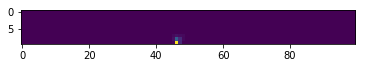

In [15]:
plt.imshow(fp_ds)
plt.show()

In [7]:
from trefide.temporal import TrendFilter

In [63]:
signal = signals[5]

In [56]:
T/18

163.0

In [73]:
ds = 2

In [74]:
signal_ds = downsample_signal(T, ds, signal)

In [75]:
signal_us = upsample_signal(T, ds, signal_ds)

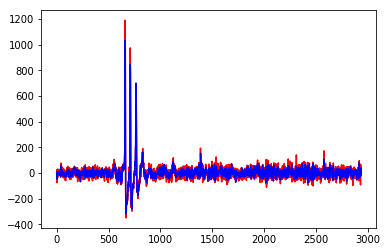

In [76]:
plt.plot(np.arange(T), signal, 'r')
plt.plot(np.arange(T), signal_us, 'b')
plt.show()

In [77]:
tf_ds = TrendFilter(T/ds)
tf_us = TrendFilter(T)
tf = TrendFilter(T)

In [78]:
tf_us.denoise(signal_us)
tf_ds.denoise(signal_ds)
tf.denoise(signal)

<MemoryView of 'ndarray' at 0x7fa1a2283be0>

In [79]:
tf_us.lambda_

57.020192417965724

In [80]:
tf_ds.lambda_

95.60722738994382

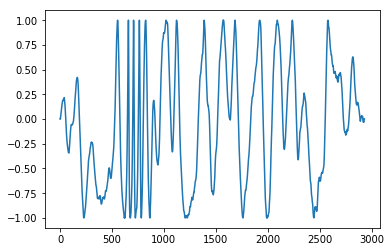

In [105]:
plt.plot(np.arange(T-2), tf.warm_start)
plt.show()

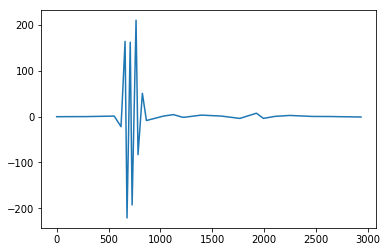

In [104]:
plt.plot(np.arange(T), tf.denoise(signal, refit=False))
plt.show()

In [103]:
tf.lambda_ = tf.lambda_*2

In [127]:
def D2(y):
    return -y[:-2] + 2 * y[1:-1] - y[2:]

In [107]:
denoised = tf.denoise(signal, refit=False)

In [128]:
diff = D2(np.asarray(denoised))

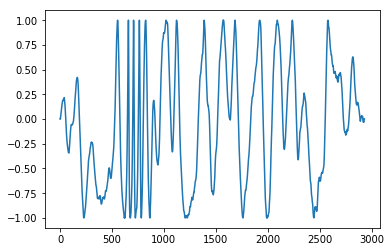

In [129]:
plt.plot(np.arange(T-2), tf.warm_start)
plt.show()

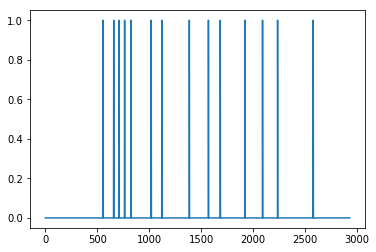

In [130]:
plt.plot(np.arange(T-2), diff >1e-5)
plt.show()

In [151]:
len(np.argwhere(diff > 1e-5))

17

In [150]:
len(np.argwhere(np.asarray(tf.warm_start) == 1))

17